In [557]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Data Understanding

In [558]:
df = pd.read_csv(r'E:\CODING\PROJECT\DATA\used car price pred\train-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [559]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [560]:
df.isna().sum()

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [561]:
df.describe()

,Unnamed: 0,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,3009.000000,2013.358199,5.873838e+04,5.278735,9.479468
std,1737.679967,3.269742,9.126884e+04,0.808840,11.187917
min,0.000000,1998.000000,1.710000e+02,0.000000,0.440000
25%,1504.500000,2011.000000,3.400000e+04,5.000000,3.500000
50%,3009.000000,2014.000000,5.300000e+04,5.000000,5.640000
75%,4513.500000,2016.000000,7.300000e+04,5.000000,9.950000
max,6018.000000,2019.000000,6.500000e+06,10.000000,160.000000


In [562]:
df.duplicated().sum()

0

In [563]:
(df['Seats']==0).sum()

1

## Preprocessing 1

In [564]:
mep_col = ['Mileage','Engine', 'Power']

for i in mep_col:
    df[i] = df[i].str.replace(r'\skm/kg|\skmpl|\sbhp|\sCC','')

df['Year'] = 2019 - df['Year'] 

In [565]:
df = df.drop(['Unnamed: 0', 'New_Price'], axis= 1)

In [566]:
df = df[df['Seats'] != 0]
df = df.dropna()
 

In [567]:
df['Name'] = df['Name'].str.split().str.get(0)

## EDA

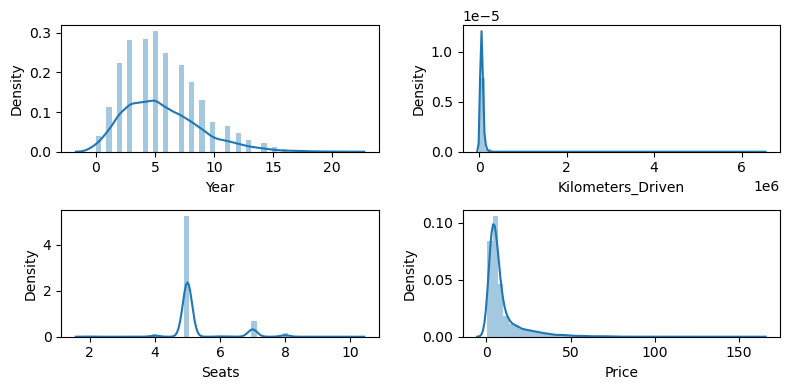

In [568]:
plt.figure(figsize=(8,4))
axes = 1
for i in df.select_dtypes(exclude='object'):
    ax = plt.subplot(2,2,axes)
    sns.distplot(df[i])
    axes += 1
    
plt.tight_layout()

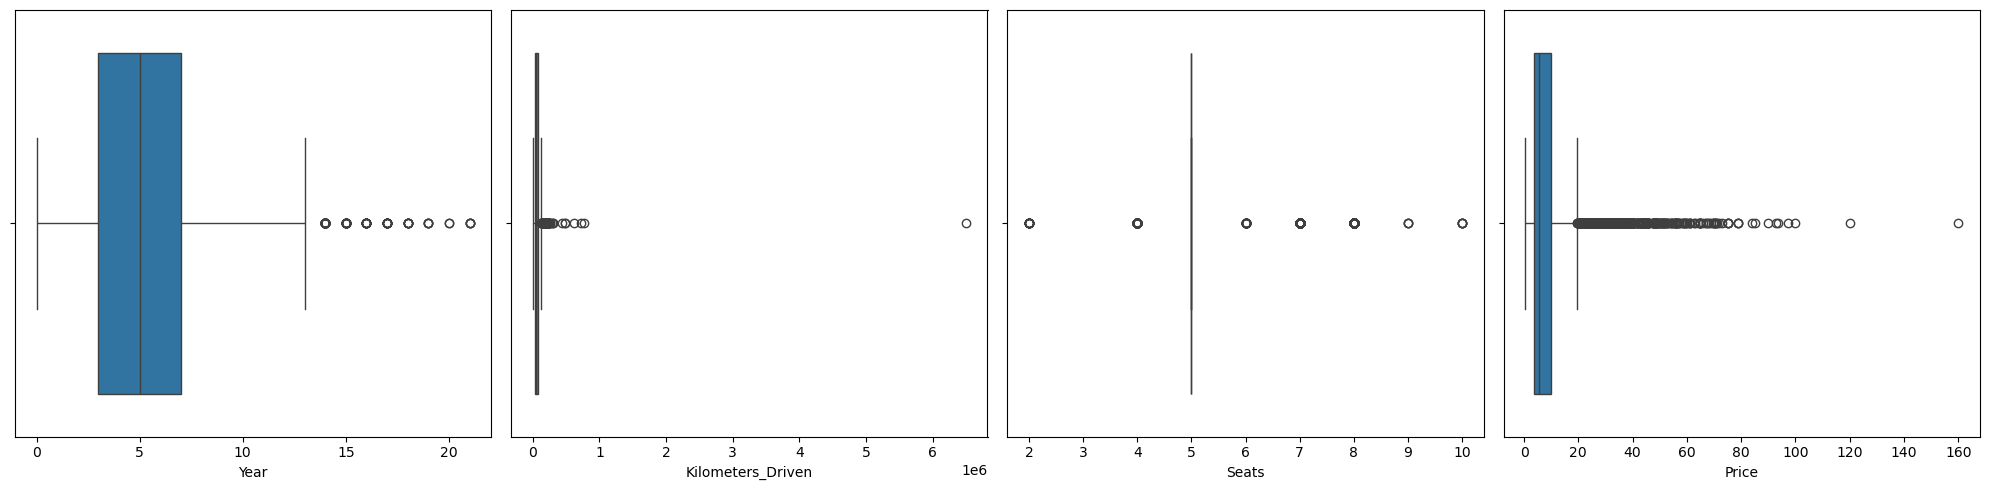

In [569]:
plt.figure(figsize=(20,5))
axes = 1
for i in df.select_dtypes(exclude='object'):
    ax = plt.subplot(1,4,axes, )
    sns.boxplot(df[i],orient='h')
    axes += 1
    
plt.tight_layout()

In [570]:
df['Location'].nunique()

11

<Axes: xlabel='Location', ylabel='count'>

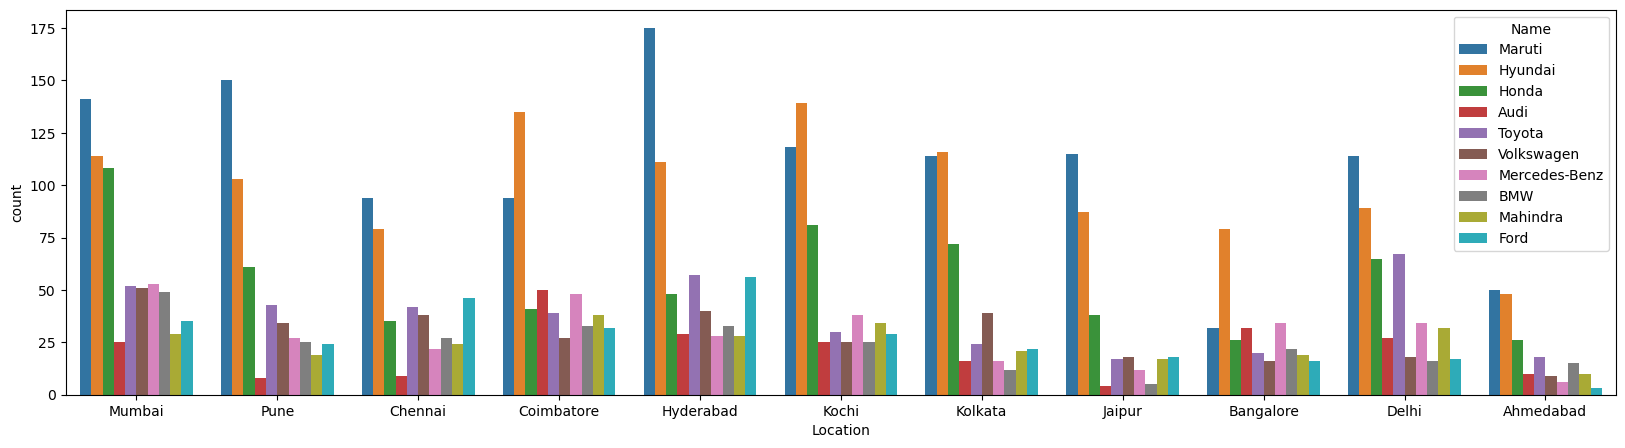

In [571]:
top10_name = df['Name'].value_counts().index[:10]
loc_by_name = df[df['Name'].isin(top10_name)]

plt.figure(figsize=(20,5))
sns.countplot(x=loc_by_name['Location'], hue=loc_by_name['Name'])

In [572]:
le = LabelEncoder()

df = df.join(pd.get_dummies(df['Fuel_Type'])).drop('Fuel_Type', axis=1)
for col in df.columns:
    df[col] = le.fit_transform(df[col]) 

<Axes: >

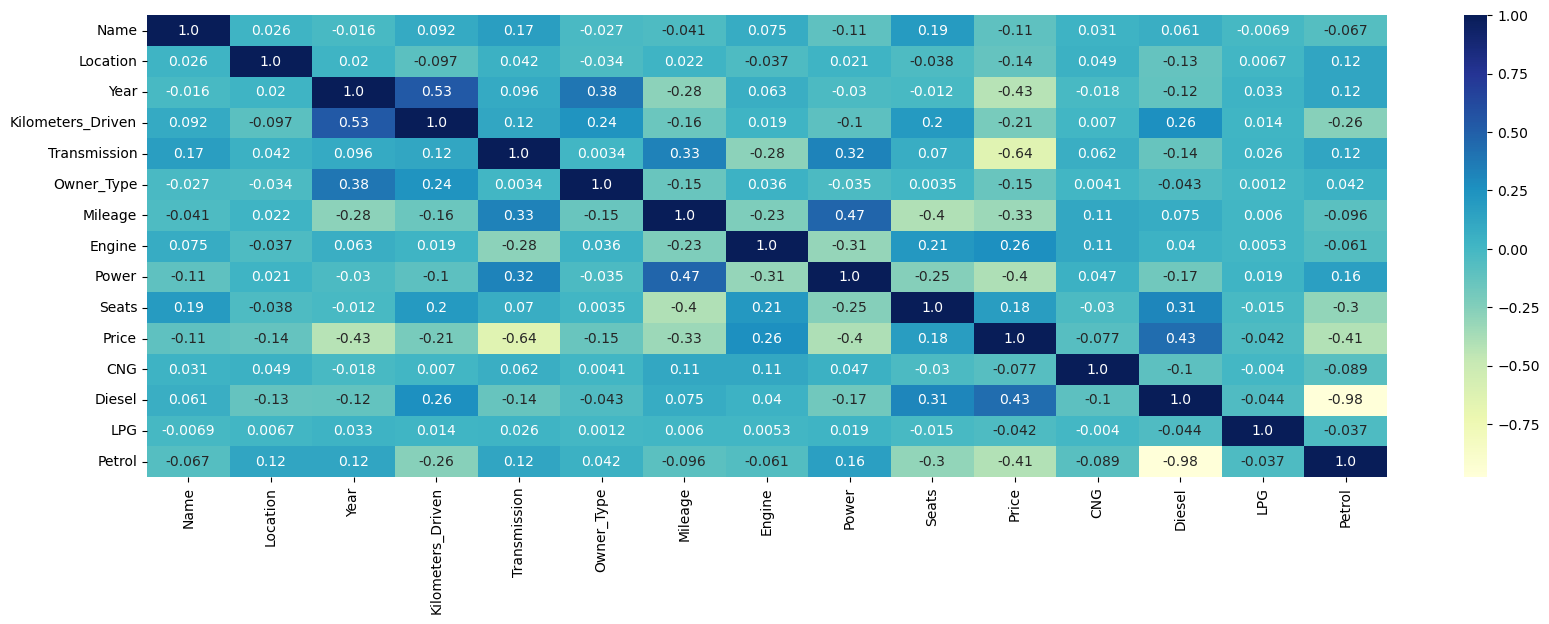

In [573]:
cor = df.corr()
plt.figure(figsize=(20,6))
sns.heatmap(cor, annot = True,fmt='.2', cmap='YlGnBu')


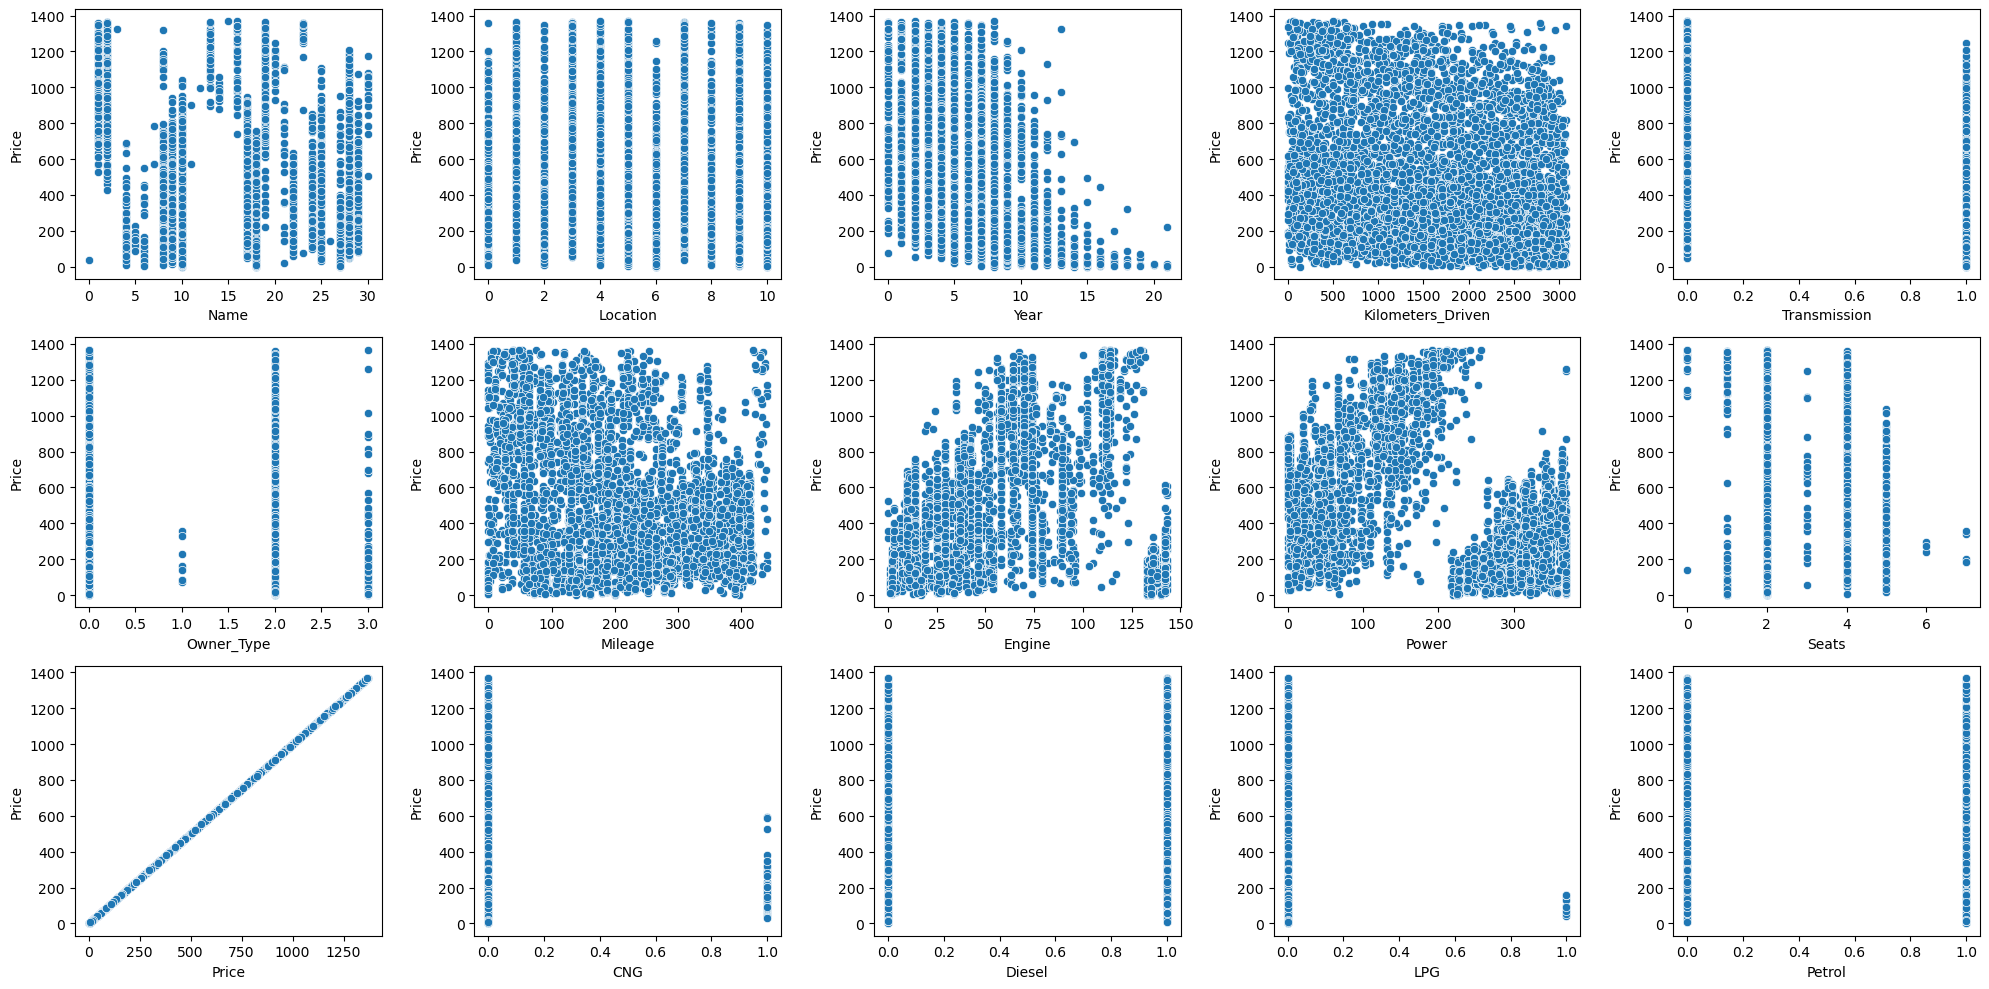

In [574]:
plt.figure(figsize=(20,10))
axes = 1

for i in df.select_dtypes(exclude='object'):
    ax = plt.subplot(3,5,axes)
    sns.scatterplot(x=df[i],y=df['Price'])
    axes += 1
    
plt.tight_layout()

## Preprocessing 2

In [575]:
x = df.drop(['Price'],axis= 1)
y = df['Price']

In [576]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size= .2, random_state=100, shuffle= True)

# MODELLING

### Hyperparameter Tuning

In [577]:
rf_param ={
            'n_estimators':[i for i in range(50,1000,50)],
            'max_depth': [i for i in range(3,45,3)],
            'min_samples_split': [i for i in range(5,40,5)],
            'random_state': [i for i in range(0,400,50)],
            'bootstrap': [True, False]
}

xgb_param = {
            'n_estimators': [i for i in range(50,1000,50)],
            'max_depth': [i for i in range(5,40)],
            'learning_rate': [0.1, 0.2, 0.3, 0.01],
            'random_state': [i for i in range(0,400,50)],
            'gamma' : [0.1, 0.2, 0.3, 0.01]
                
}

def tuning(model,param):
    gsearch = RandomizedSearchCV(estimator= model, param_distributions= param, cv = 50, n_jobs= -1, scoring= 'neg_mean_squared_error')
    gsearch.fit(xtrain,ytrain)
    return print(f'Score = {gsearch.best_score_}\nParameter = {gsearch.best_params_}')


In [578]:
# tuning(rf,rf_param)

# tuning(xgb, xgb_param)

### Linear Regression

In [579]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
lr_pred = lr.predict(xtest)

### Random Forest 

In [580]:
rf = RandomForestRegressor(random_state = 350, n_estimators = 500, 
                           min_samples_split = 15, max_depth = 36,
                           bootstrap = True)

rf.fit(xtrain,ytrain)
rf_pred = rf.predict(xtest)

### XGBoost

In [581]:
xgb = XGBRegressor( n_estimators=500, max_depth= 10, gamma =0.2,random_state = 150, learning_rate = 0.01)

xgb.fit(xtrain, ytrain)
xgb_pred = xgb.predict(xtest)

## EVALUATION

In [582]:
lr_r2 = r2_score(ytest,lr_pred)
lr_mae = mean_absolute_error(ytest,lr_pred)
lr_rmse = np.sqrt(mean_squared_error(ytest,lr_pred))

rf_r2 = r2_score(ytest,rf_pred)
rf_mae = mean_absolute_error(ytest,rf_pred)
rf_rmse = np.sqrt(mean_squared_error(ytest,rf_pred))

xgb_r2 = r2_score(ytest,xgb_pred)
xgb_mae = mean_absolute_error(ytest,xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(ytest,xgb_pred))

In [583]:
eval_cols = {
    'Model': ['LR','RF','XGB'],
    'r2': [lr_r2,rf_r2,xgb_r2],
    'MAE': [lr_mae,rf_mae,xgb_mae],
    'RMSE': [lr_rmse,rf_rmse,xgb_rmse], }

evaluation = pd.DataFrame(eval_cols)
evaluation

,Model,r2,MAE,RMSE
0,LR,0.761310,128.129708,170.264225
1,RF,0.947446,57.510787,79.893266
2,XGB,0.958536,49.894265,70.964369


In [584]:
hasil = pd.DataFrame({'Test':ytest, 'LR':lr_pred, 'RF':rf_pred, 'XGB': xgb_pred })
hasil

,Test,LR,RF,XGB
4520,683,550.739232,588.223298,539.863281
1403,186,274.813213,233.261990,254.593689
1839,345,317.284952,430.417483,397.471161
3671,254,268.175093,176.126148,216.301071
1950,167,151.097497,184.500491,175.453140
...,...,...,...,...
4877,675,526.416273,692.840473,744.874268
2756,388,304.710132,382.468716,391.924713
1095,201,272.846084,118.815939,120.688911
5767,674,875.878619,720.740338,745.483582
